
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Validation of the synthetic waves and level

inputs required: 
  * historical wave conditions
  * emulator output - synthetic wave conditions
  
in this notebook:
  * Validation of the extreme distributions
  * Analysis of the DWT resposible of extreme TWL events (from the historical and synthetic datasets)
  


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.extremes import Peaks_Over_Threshold as POT
from teslakit.util.time_operations import xds_reindex_daily

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation
from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT
from teslakit.plotting.outputs import Plot_LevelVariables_Histograms



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data =  r'/Users/anacrueda/Documents/Proyectos/TESLA/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# Load complete hourly data for extremes analysis

# Historical
HIST_C_h = db.Load_HIST_OFFSHORE(decode_times=True)

# Simulation
SIM_C_h = db.Load_SIM_OFFSHORE_all(decode_times=True, use_cftime=True)


In [4]:
print(SIM_C_h)

<xarray.Dataset>
Dimensions:     (n_sim: 10, time: 8765832)
Coordinates:
  * time        (time) object 2000-01-01 00:00:00 ... 2999-12-31 23:00:00.13
  * n_sim       (n_sim) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    SS          (time, n_sim) float64 ...
    MJO         (time, n_sim) float64 ...
    level       (time, n_sim) float64 ...
    TWL         (time, n_sim) float64 ...
    AWT         (time, n_sim) float64 ...
    AWL         (time, n_sim) float64 ...
    max_storms  (time, n_sim) float64 ...
    MMSL        (time, n_sim) float64 ...
    Dir         (time, n_sim) float64 ...
    DWT         (time, n_sim) float64 ...
    AT          (time, n_sim) float64 ...
    Tp          (time, n_sim) float64 ...
    Hs          (time, n_sim) float64 ...


In [5]:
# def. some auxiliar function to select all dataset variables at vn max by groups

def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})



## AWL - Annual Maxima Calculation

In [6]:
# Historical AWL Annual Maxima

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_C_h['AWL'].values[:])))
HIST_C_nonan = HIST_C_h.isel(time = ix_nonan)

# calculate AWL annual maxima dataset
hist_AMax = HIST_C_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


In [7]:
# Simulation AWL Annual Maxima

# calculate AWL annual maxima dataset
sim_AMax = SIM_C_h.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')
print(sim_AMax)

<xarray.Dataset>
Dimensions:     (n_sim: 10, year: 1000)
Coordinates:
  * n_sim       (n_sim) int64 0 1 2 3 4 5 6 7 8 9
    time        (year, n_sim) object 2000-03-23 03:00:00 ... 2999-03-17 22:00:00
  * year        (year) int64 2000 2001 2002 2003 2004 ... 2996 2997 2998 2999
Data variables:
    SS          (year, n_sim) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.135 0.0 0.0
    MJO         (year, n_sim) float64 25.0 12.0 11.0 11.0 ... 24.0 22.0 25.0
    level       (year, n_sim) float64 0.03994 0.1905 0.008224 ... 0.263 0.0113
    TWL         (year, n_sim) float64 1.2 1.388 1.042 1.526 ... 1.639 1.68 1.154
    AWT         (year, n_sim) float64 3.0 4.0 4.0 4.0 3.0 ... 5.0 1.0 2.0 2.0
    AWL         (year, n_sim) float64 1.16 1.197 1.033 ... 1.349 1.417 1.143
    max_storms  (year, n_sim) float64 0.0 1.0 0.0 1.0 0.0 ... 0.0 0.0 0.0 0.0
    MMSL        (year, n_sim) float64 0.05693 0.0198 ... -0.07293 -0.06517
    Dir         (year, n_sim) float64 322.5 333.0 344.8 ... 37.92 7.627 73.66
  


## AWL - Annual Maxima Return Period

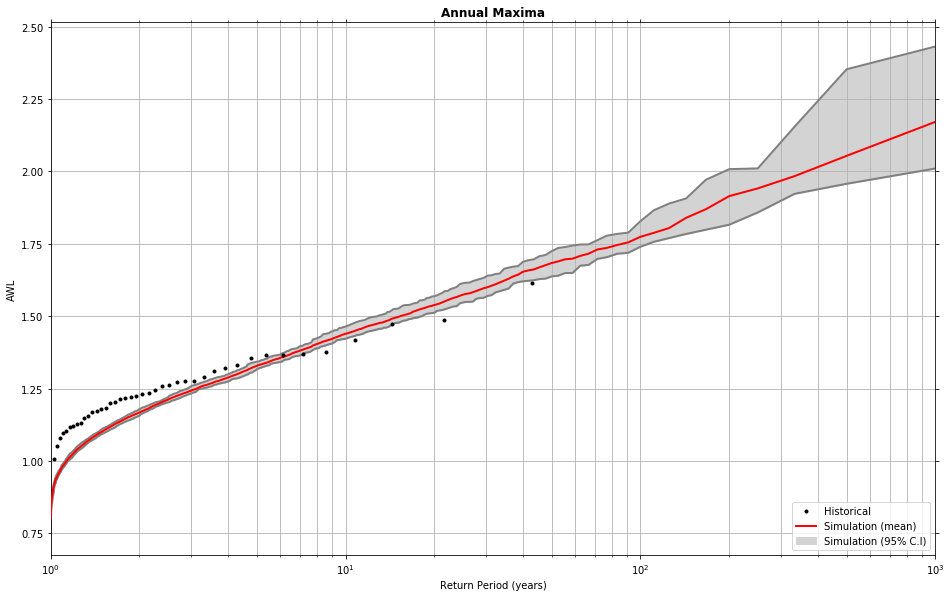

In [7]:
# AWL Annual Maxima Return Period (historical vs. simulations)

Plot_ReturnPeriodValidation(hist_AMax['AWL'], sim_AMax['AWL'].transpose());


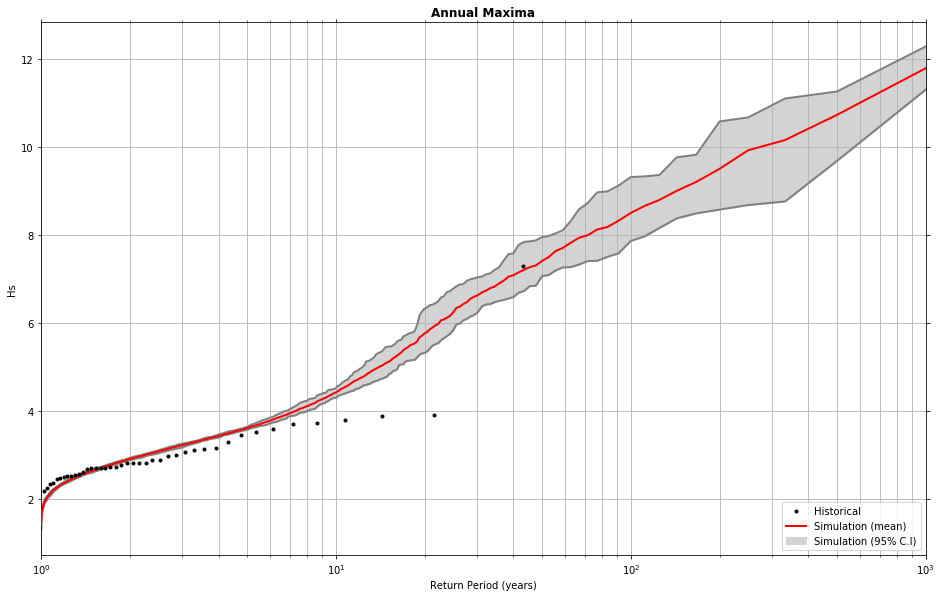

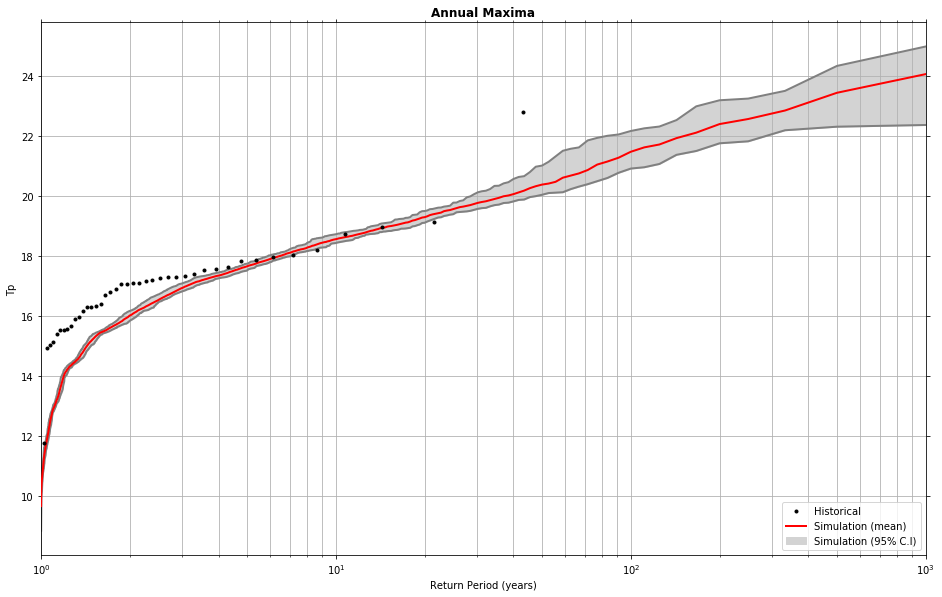

In [8]:
# Hs and Tp Return Period (historical vs. simulations) at AWL Annual Maxima

# Hs at AWL Annual Maxima
Plot_ReturnPeriodValidation(hist_AMax['Hs'], sim_AMax['Hs'].transpose());

# Tp at AWL Annual Maxima
Plot_ReturnPeriodValidation(hist_AMax['Tp'], sim_AMax['Tp'].transpose());



## AWL - Annual Maxima Probabilistic Plots

In [9]:
# Probabilistic plots parameters

n_clusters_AWT = 6    # number of AWT clusters
n_clusters_DWT = 42   # number of DWT clusters

# Select one simulation DWTs - WAVEs simulation
n_sim = 0
sim_AMax_n = sim_AMax.sel(n_sim=0)


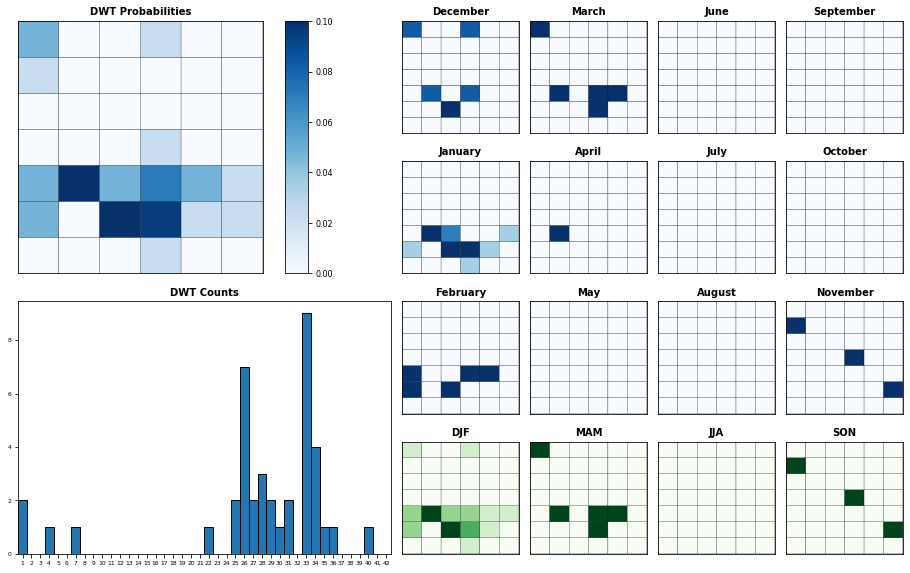

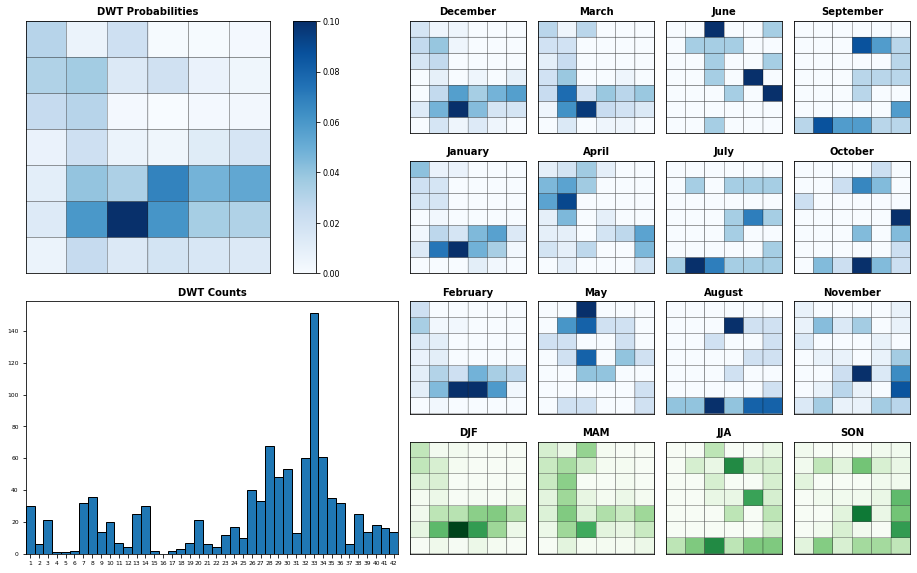

In [10]:
# Plot Annual Maxima DWT probabilities by month

# Historical
Plot_DWTs_Probs(hist_AMax['DWT'].values, hist_AMax.time.values, n_clusters_DWT);

# Simulation
Plot_DWTs_Probs(sim_AMax_n['DWT'].values, sim_AMax_n.time.values, n_clusters_DWT);


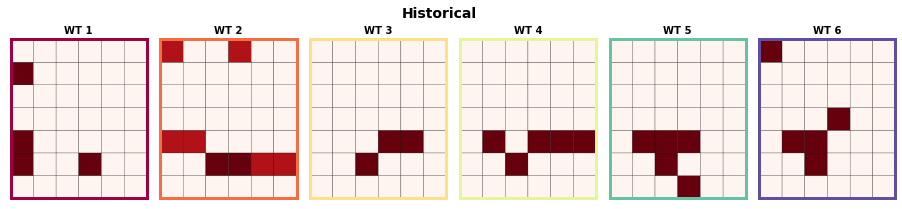

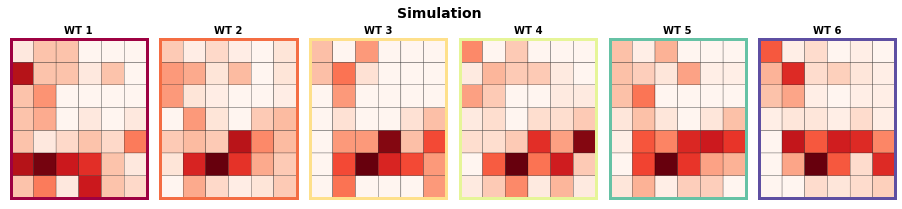

In [11]:
# Plot Annual Maxima AWTs/DWTs Probabilities 

# Historical
Plot_Probs_WT_WT(
    hist_AMax['AWT'].values - 1, hist_AMax['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Historical',
);

# Simulation 
Plot_Probs_WT_WT(
    sim_AMax_n['AWT'].values[:] - 1, sim_AMax_n['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Simulation',
);



## AWL - Peaks Over Threshold Calculation

In [12]:
# POT  plots parameters

n_clusters_AWT = 6    # number of AWT clusters
n_clusters_DWT = 42   # number of DWT clusters

# Select one simulation DWTs - WAVEs simulation
n_sim = 0
SIM_C_h_n = SIM_C_h.sel(n_sim=0)


# TODO: update POT to work with hourly data
_, ix = np.unique(SIM_C_h_n['time'], return_index=True)  
SIM_C_h_n = SIM_C_h_n.isel(time=ix)

# Parse data to daily 
HIST_C_d = xds_reindex_daily(HIST_C_nonan)  # TODO: check possible bug if this puts NAN inside AWL data
SIM_C_d_n = xds_reindex_daily(SIM_C_h_n)


In [13]:
# Get independent event peaks (99 percentile)

# Historical
times_POT = POT(HIST_C_d.isel(time=slice(1,-1)), 'AWL', 99).time  # TODO: check possible awl nan bug
hist_POT = HIST_C_d.sel(time = times_POT)

# Simulation
times_POT = POT(SIM_C_d_n, 'AWL', 99).time
sim_POT = SIM_C_d_n.sel(time = times_POT)



## AWL - Peaks Over Threshold Probabilistic Plots

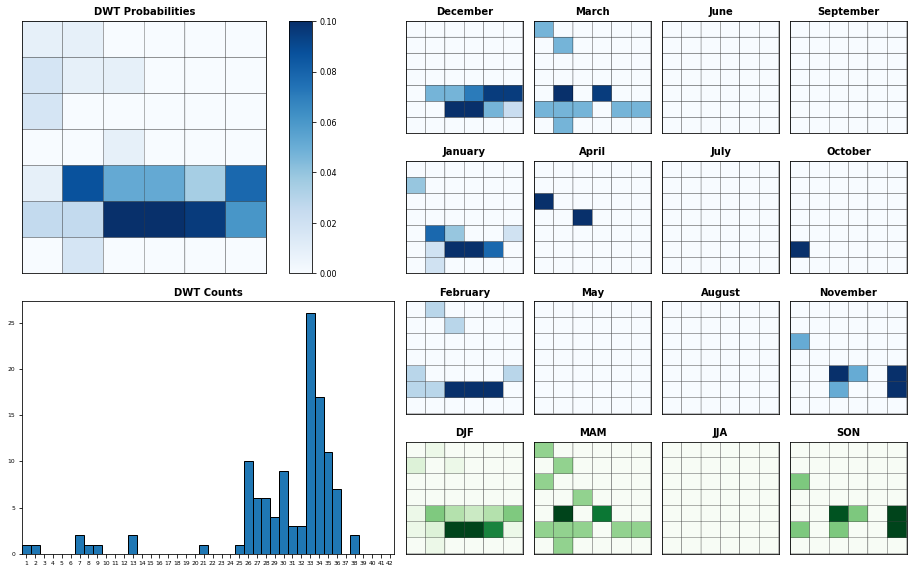

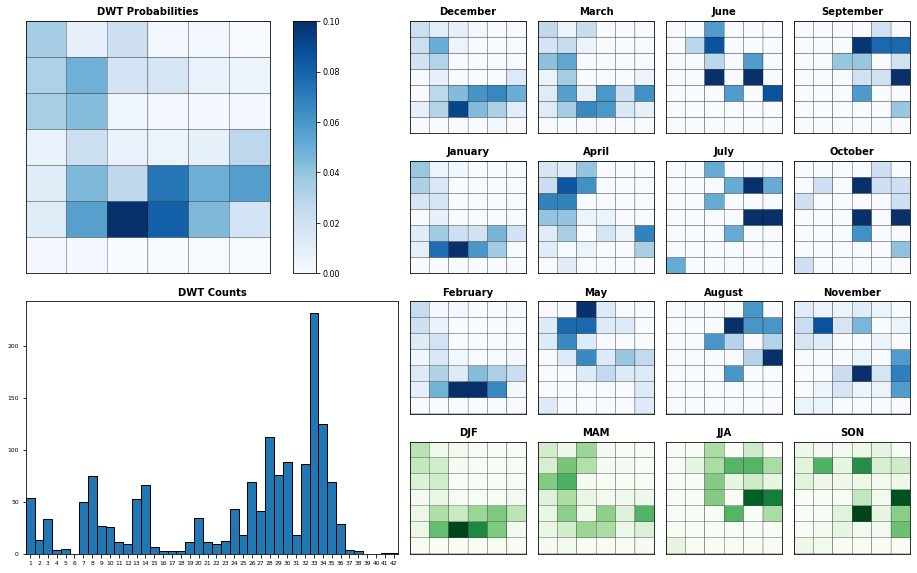

In [14]:
# Plot Peaks Over Threshold DWT probabilities by month

# Historical
Plot_DWTs_Probs(hist_POT['DWT'].values, hist_POT.time.values, n_clusters_DWT);

# Simulation
Plot_DWTs_Probs(sim_POT['DWT'].values, sim_POT.time.values, n_clusters_DWT);


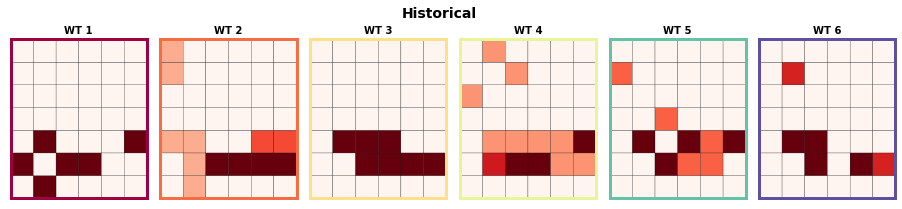

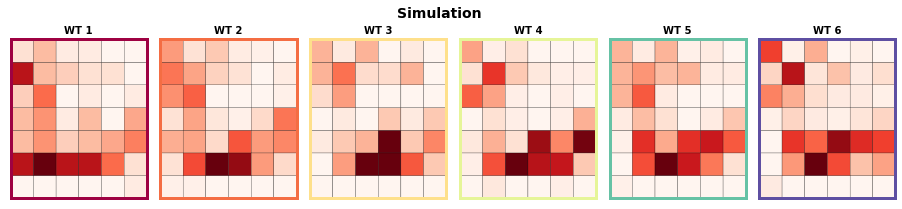

In [15]:
# Plot Peaks Over Threshold AWTs/DWTs Probabilities 

# Historical
Plot_Probs_WT_WT(
    hist_POT['AWT'].values - 1, hist_POT['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Historical',
);

# Simulation 
Plot_Probs_WT_WT(
    sim_POT['AWT'].values[:] - 1, sim_POT['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Simulation',
);



## Level Variables (level, AT, MMSL, TWL) - Histograms

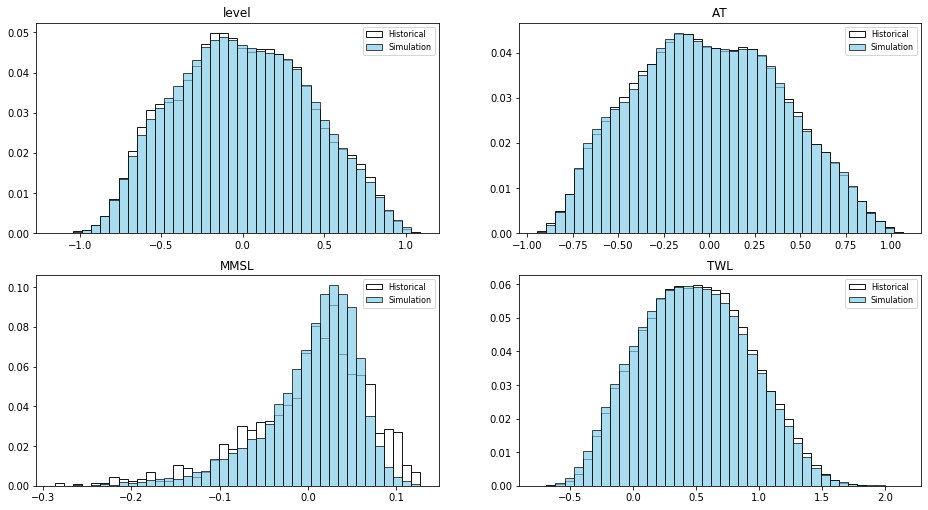

In [16]:

# Plot level, AT, MMSL and TWL histogram comparison between historical and simulated data
Plot_LevelVariables_Histograms(HIST_C_h, SIM_C_h.sel(n_sim = 0));


In [19]:
print(np.mean(HIST_C_h.AT))
print(np.mean(SIM_C_h.AT.sel(n_sim = 0)))
print()
print(np.mean(HIST_C_h.level))
print(np.mean(SIM_C_h.level.sel(n_sim = 0)))
print()
print(np.mean(HIST_C_h.MMSL))
print(np.mean(SIM_C_h.MMSL.sel(n_sim = 0)))
print()
print(np.mean(HIST_C_h.TWL))
print(np.mean(SIM_C_h.TWL.sel(n_sim = 0)))

<xarray.DataArray 'AT' ()>
array(-5.98787516e-18)
<xarray.DataArray 'AT' ()>
array(-3.19821111e-09)
Coordinates:
    n_sim    int64 0

<xarray.DataArray 'level' ()>
array(0.00130101)
<xarray.DataArray 'level' ()>
array(0.0044761)
Coordinates:
    n_sim    int64 0

<xarray.DataArray 'MMSL' ()>
array(0.00125788)
<xarray.DataArray 'MMSL' ()>
array(0.00439754)
Coordinates:
    n_sim    int64 0

<xarray.DataArray 'TWL' ()>
array(0.50304684)
<xarray.DataArray 'TWL' ()>
array(0.48307342)
Coordinates:
    n_sim    int64 0



## TWL - Annual Maxima

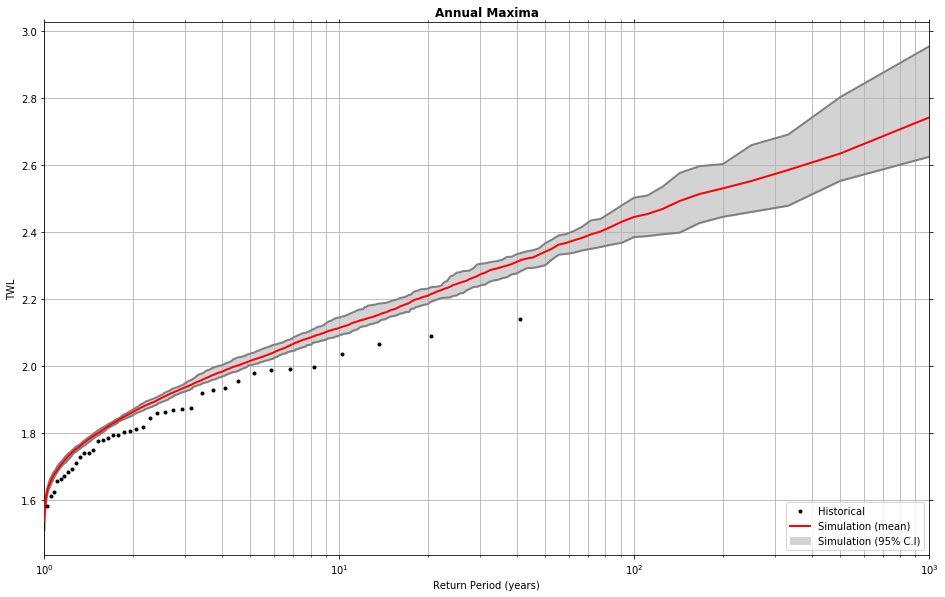

In [17]:
# Plot TWL annual maxima

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_C_h['TWL'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h['TWL'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());


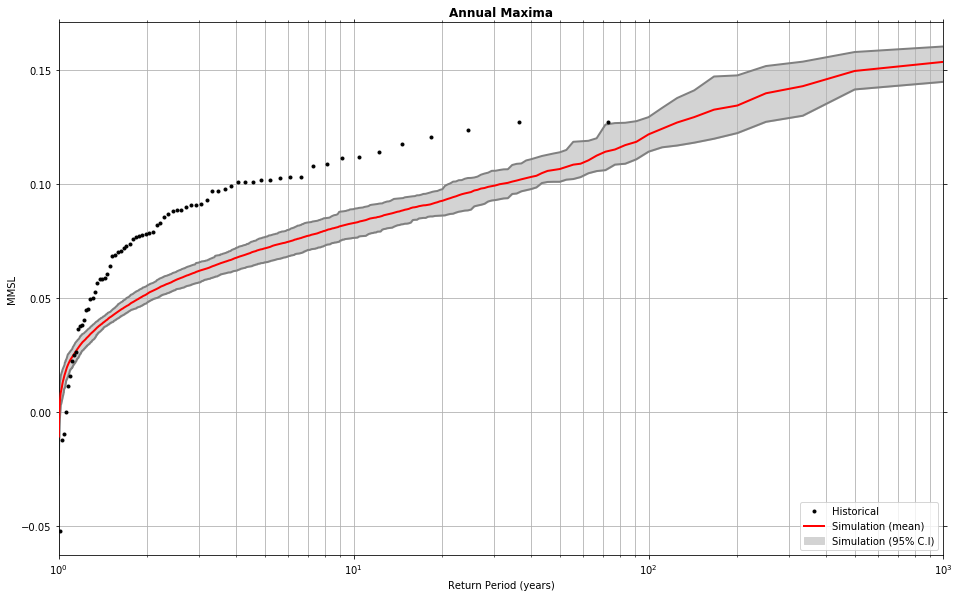

In [20]:

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_C_h['MMSL'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h['MMSL'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());


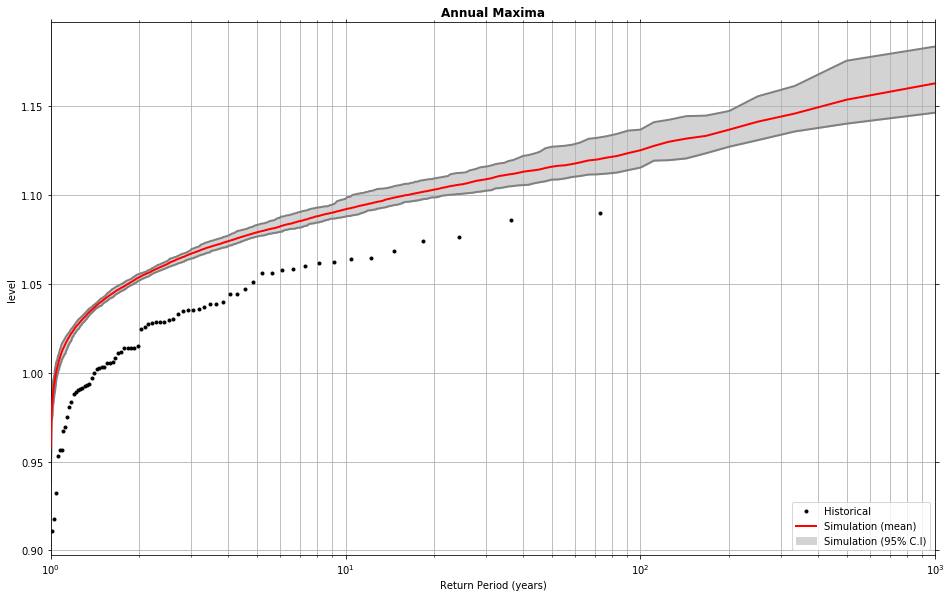

In [21]:

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_C_h['level'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h['level'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());


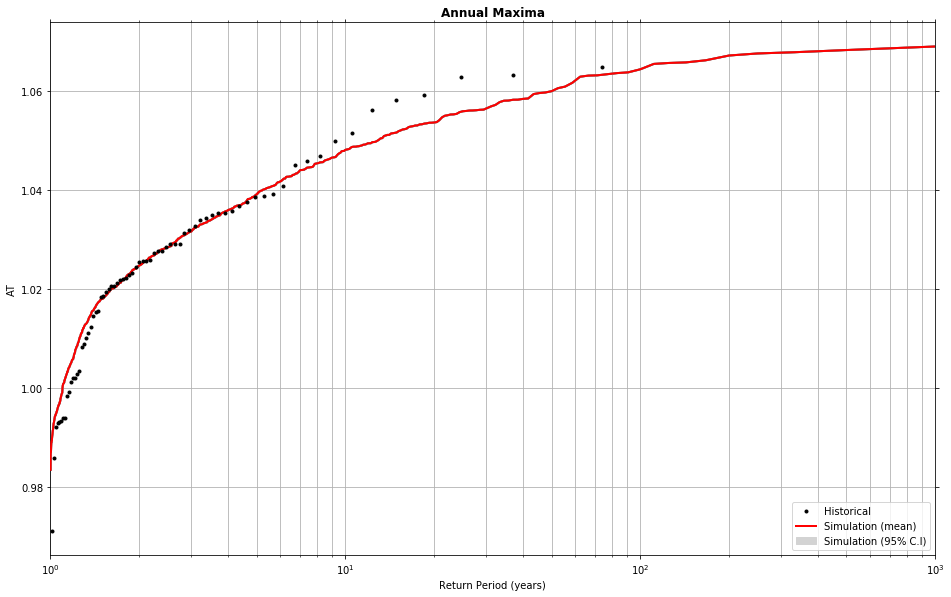

In [22]:

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_C_h['AT'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h['AT'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());
